In [382]:
import json
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import sequence
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers.embeddings import Embedding


In [414]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))
    

In [415]:
#create custom f1 metric from custom recall and precision
from keras.layers import concatenate
from keras import backend as K

def recall_m(y_true, y_pred): # recall is true positive / (total actual positive)
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # y_true * y_pred will only give 1 for true positives
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) # actual positives are just y_true
        # recall is true positive / (total actual positive).. the episol is a small number to prevent divide by zero errors
        recall = true_positives / (possible_positives + K.epsilon()) 
        return recall

def precision_m(y_true, y_pred): #precision is true positives / (total predicted positives)
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # y_true * y_pred will only give 1 for true positives
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) # predicted positives
        # (true positive / predicted positive).. the episol is a small number to prevent divide by zero errors
        precision = true_positives / (predicted_positives + K.epsilon())   
        return precision

def f1_m(y_true, y_pred): # f1 = 2 * (precision*recall / precision + recall)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon())) 

In [351]:
tweets = []
article_link = []
headline=[]
y = []

for line in open('C:/Users/sulem/OneDrive/Desktop/machin learnign/project7/Sarcasm_Headlines_Dataset.json', 'r'):
    tweets.append(json.loads(line))
    article_link.append(tweets[len(tweets)-1]['article_link'])
    headline.append(tweets[len(tweets)-1]['headline'])
    y.append(tweets[len(tweets)-1]['is_sarcastic'])

In [352]:
NUM_TOP_WORDS = None
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(headline)
sequences = tokenizer.texts_to_sequences(headline)

In [362]:
MAX_ART_LEN = 500 # maximum and minimum number of words
word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))


Found 29656 unique tokens. Distilled to 29656 top words.


In [363]:
X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

In [365]:
y_ohe = keras.utils.to_categorical(y)

In [444]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
sss=StratifiedShuffleSplit(n_splits=3, random_state=7,train_size = .8,test_size = .2,)
# Split it into train / test subsets

X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2,
                                                            stratify=y, 
                                                            random_state=42)

In [376]:
import numpy as np
NUM_CLASSES = 2
print(X_train.shape,y_train_ohe.shape)
print(np.sum(y_train_ohe,axis=0))

(21367, 500) (21367, 2)
[11988.  9379.]


In [445]:

EMBED_SIZE = 50
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))

input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN)(input_holder) # number of words in each sequence


x = SimpleRNN(50,dropout=0.2, recurrent_dropout=0.2)(input_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
rnn=Model(inputs=input_holder,outputs=x)
rnn.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 500, 50)           1482850   
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 50)                5050      
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 102       
Total params: 1,488,002
Trainable params: 1,488,002
Non-trainable params: 0
_________________________________________________________________
None


## Network 1 

In [446]:
history1=[]
for train_index, test_index in sss.split(X, y_ohe):
 input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN)(input_holder) # number of words in each sequence


 x = SimpleRNN(50,dropout=0.2, recurrent_dropout=0.2)(input_embed)
 x = Dense(NUM_CLASSES, activation='sigmoid')(x)
 print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
 rnn=Model(inputs=input_holder,outputs=x)
 rnn.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
 X_train, X_test = X[train_index], X[test_index]
 y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]   
 history1.append(rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64))

TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 77s 4ms/step - loss: 0.6956 - acc: 0.5381 - f1_m: 0.5349 - val_loss: 0.6653 - val_acc: 0.5663 - val_f1_m: 0.5671
Epoch 2/5
21367/21367 [==============================] - 61s 3ms/step - loss: 0.6366 - acc: 0.6342 - f1_m: 0.6354 - val_loss: 0.5585 - val_acc: 0.7228 - val_f1_m: 0.7220
Epoch 3/5
21367/21367 [==============================] - 59s 3ms/step - loss: 0.5203 - acc: 0.7429 - f1_m: 0.7433 - val_loss: 0.4777 - val_acc: 0.7714 - val_f1_m: 0.7724
Epoch 4/5
21367/21367 [==============================] - 58s 3ms/step - loss: 0.4228 - acc: 0.8083 - f1_m: 0.8086 - val_loss: 0.4131 - val_acc: 0.8154 - val_f1_m: 0.8153
Epoch 5/5
21367/21367 [==============================] - 59s 3ms/step - loss: 0.3515 - acc: 0.8512 - f1_m: 0.8512 - val_loss: 0.3802 - val_acc: 0.8402 - val_f1_m: 0.8405
TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 

## Network 2 

In [471]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
history2=[]
for train_index, test_index in sss.split(X, y_ohe):
 input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN) # number of words in each sequence
 rnnls = Sequential()
 rnnls.add(input_embed)
 rnnls.add(LSTM(50,dropout=0.2, recurrent_dropout=0.2))
 rnnls.add(Dense(NUM_CLASSES, activation='sigmoid'))
 rnnls.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
 print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
 X_train, X_test = X[train_index], X[test_index]
 y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]
 rnnls.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
 history2.append(rnnls.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64))
print(rnnls.summary())

TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 156s 7ms/step - loss: 0.5012 - acc: 0.7568 - f1_m: 0.7501 - val_loss: 0.3412 - val_acc: 0.8532 - val_f1_m: 0.8482
Epoch 2/5
21367/21367 [==============================] - 154s 7ms/step - loss: 0.3134 - acc: 0.8705 - f1_m: 0.8668 - val_loss: 0.3190 - val_acc: 0.8618 - val_f1_m: 0.8603
Epoch 3/5
21367/21367 [==============================] - 153s 7ms/step - loss: 0.2580 - acc: 0.8984 - f1_m: 0.8973 - val_loss: 0.3121 - val_acc: 0.8677 - val_f1_m: 0.8640
Epoch 4/5
21367/21367 [==============================] - 152s 7ms/step - loss: 0.2106 - acc: 0.9168 - f1_m: 0.9156 - val_loss: 0.3146 - val_acc: 0.8695 - val_f1_m: 0.8678
Epoch 5/5
21367/21367 [==============================] - 150s 7ms/step - loss: 0.2071 - acc: 0.9237 - f1_m: 0.9232 - val_loss: 0.3179 - val_acc: 0.8714 - val_f1_m: 0.8685
TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 

## Network 2 

In [472]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
history3=[]
for train_index, test_index in sss.split(X, y_ohe):
 input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN) # number of words in each sequence
 rnngd = Sequential()
 rnngd.add(input_embed)
 rnngd.add(GRU(50,dropout=0.2, recurrent_dropout=0.2))
 rnngd.add(Dense(NUM_CLASSES, activation='sigmoid'))
 rnngd.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
 print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
 X_train, X_test = X[train_index], X[test_index]
 y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]
 rnngd.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
 history3.append(rnngd.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64))
print(rnngd.summary())

TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 159s 7ms/step - loss: 0.4816 - acc: 0.7611 - f1_m: 0.7567 - val_loss: 0.3382 - val_acc: 0.8510 - val_f1_m: 0.8485
Epoch 2/5
21367/21367 [==============================] - 144s 7ms/step - loss: 0.2967 - acc: 0.8782 - f1_m: 0.8767 - val_loss: 0.3207 - val_acc: 0.8613 - val_f1_m: 0.8590
Epoch 3/5
21367/21367 [==============================] - 144s 7ms/step - loss: 0.2388 - acc: 0.9047 - f1_m: 0.9024 - val_loss: 0.3115 - val_acc: 0.8656 - val_f1_m: 0.8626
Epoch 4/5
21367/21367 [==============================] - 156s 7ms/step - loss: 0.2029 - acc: 0.9191 - f1_m: 0.9189 - val_loss: 0.3095 - val_acc: 0.8675 - val_f1_m: 0.8682
Epoch 5/5
21367/21367 [==============================] - 161s 8ms/step - loss: 0.1873 - acc: 0.9276 - f1_m: 0.9275 - val_loss: 0.3102 - val_acc: 0.8701 - val_f1_m: 0.8680
TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 

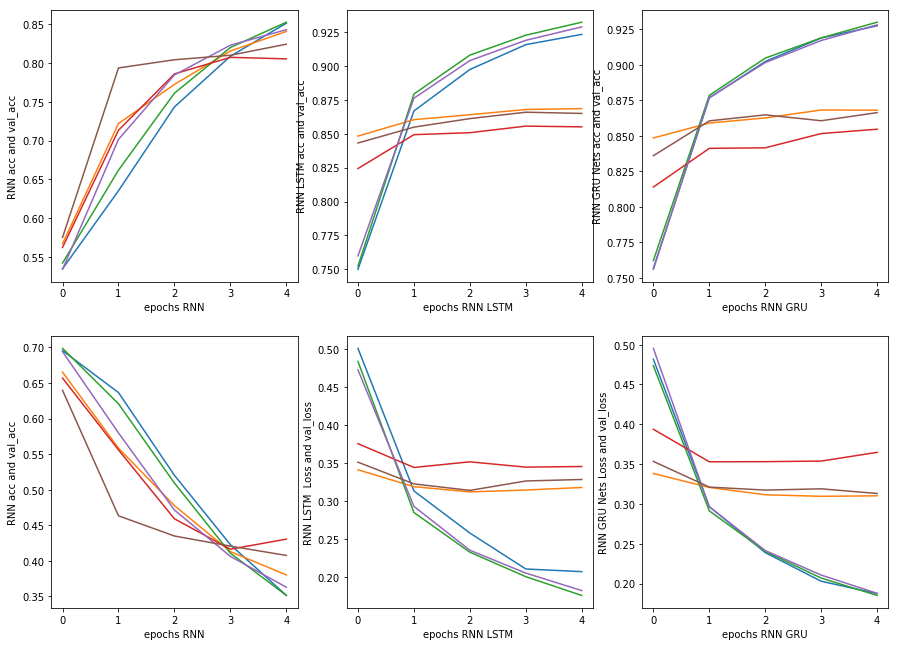

In [473]:
plt.figure(figsize=(15,11))
plt.subplot(2,3,1)
plt.ylabel('RNN acc and val_acc')
plt.xlabel('epochs RNN')
plt.plot(history1[0].history['f1_m'])

plt.plot(history1[0].history['val_f1_m'])
plt.plot(history1[1].history['f1_m'])

plt.plot(history1[1].history['val_f1_m'])
plt.plot(history1[2].history['f1_m'])

plt.plot(history1[2].history['val_f1_m'])
plt.subplot(2,3,4)
plt.ylabel('RNN acc and val_acc')
plt.plot(history1[0].history['loss'])
plt.xlabel('epochs RNN')
plt.plot(history1[0].history['val_loss'])

plt.plot(history1[1].history['loss'])
plt.plot(history1[1].history['val_loss'])
plt.plot(history1[2].history['loss'])
plt.plot(history1[2].history['val_loss']) 
         
plt.subplot(2,3,2)
plt.ylabel('RNN LSTM acc and val_acc')
plt.xlabel('epochs RNN LSTM ')
plt.plot(history2[0].history['f1_m'])
plt.plot(history2[0].history['val_f1_m'])
plt.plot(history2[1].history['f1_m'])
plt.plot(history2[1].history['val_f1_m'])
plt.plot(history2[2].history['f1_m'])
plt.plot(history2[2].history['val_f1_m'])
plt.subplot(2,3,5)
plt.plot(history2[0].history['loss'])
plt.ylabel('RNN LSTM  Loss and val_loss')
plt.plot(history2[0].history['val_loss'])
plt.xlabel('epochs RNN LSTM ')
plt.plot(history2[1].history['loss'])
plt.plot(history2[1].history['val_loss'])
plt.plot(history2[2].history['loss'])
plt.plot(history2[2].history['val_loss'])
plt.subplot(2,3,3)
plt.ylabel('RNN GRU Nets acc and val_acc')
plt.xlabel('epochs RNN GRU')
plt.plot(history3[0].history['f1_m'])
plt.plot(history3[0].history['val_f1_m'])
plt.plot(history3[1].history['f1_m'])
plt.plot(history3[1].history['val_f1_m'])
plt.plot(history3[2].history['f1_m'])
plt.plot(history3[2].history['val_f1_m'])
plt.subplot(2,3,6)
plt.plot(history3[0].history['loss'])
plt.ylabel('RNN GRU Nets Loss and val_loss')
plt.plot(history3[0].history['val_loss'])
plt.xlabel('epochs RNN GRU')
plt.plot(history3[1].history['loss'])
plt.plot(history3[1].history['val_loss'])
plt.plot(history3[2].history['loss'])
plt.plot(history3[2].history['val_loss'])




the graph per epochs showes that GRU and LSTN did better than simple RNN but its still not opviouse which classfier did the best so we will use macnima test to find that 

In [ ]:
# copy ytest for reshape
yhat_sim=[]
yhat_ls=[]
yhat_gru=[]
for train_index, test_index in sss.split(X, y_ohe):
    yhat_sim.append(np.argmax(rnn.predict(X_test), axis=1))
    yhat_ls.append(np.argmax(rnnls.predict(X_test), axis=1))
    yhat_gru.append(np.argmax(rnngd.predict(X_test), axis=1))
    

In [827]:
from statsmodels.stats.contingency_tables import mcnemar


    
# build contingency table
contab = pd.DataFrame({'sim_correct':np.equal(y_test_ohe[:,1], yhat_sim[0]).flatten(),'ls_correct':np.equal(y_test_ohe[:,1], yhat_ls[0]).flatten(),'gre_correct':np.equal(y_test_ohe[:,1], yhat_gru[0]).flatten()},index=range(0,len(y_test_ohe[:,1])))
contab1 = pd.DataFrame({'sim_correct1':np.equal(y_test_ohe[:,1], yhat_sim[1]).flatten(),'ls_correct1':np.equal(y_test_ohe[:,1], yhat_ls[1]).flatten(),'gre_correct1':np.equal(y_test_ohe[:,1], yhat_gru[1]).flatten()},index=range(0,len(y_test_ohe[:,1])))
contab2 = pd.DataFrame({'sim_correct2':np.equal(y_test_ohe[:,1], yhat_sim[2]).flatten(),'ls_correct2':np.equal(y_test_ohe[:,1], yhat_ls[2]).flatten(),'gre_correct2':np.equal(y_test_ohe[:,1], yhat_gru[2]).flatten()},index=range(0,len(y_test_ohe[:,1])))
xtab = pd.crosstab(contab.sim_correct, contab.ls_correct)
xtab1 = pd.crosstab(contab.ls_correct, contab.gre_correct)
xtab.sort_index(ascending=False, inplace=True)
xtab.sort_index(ascending=False, inplace=True, axis=1)
print('Contingency table for McNemar Test:\n', xtab, '\n')
print('lst test was superior to the simple test because it got more corrent predection in the true false cell ')
print('Contingency table for McNemar Test:\n', xtab1, '\n')
print('GRE test was superior to the other test because it got more corrent predection than the other two ')

xtab = pd.crosstab(contab1.sim_correct1, contab1.ls_correct1)
xtab1 = pd.crosstab(contab1.ls_correct1, contab1.gre_correct1)
xtab.sort_index(ascending=False, inplace=True)
xtab.sort_index(ascending=False, inplace=True, axis=1)
print('Contingency table for McNemar Test:\n', xtab, '\n')
print('lst test was superior to the simple test because it got more corrent predection in the true false cell ')
print('Contingency table for McNemar Test:\n', xtab1, '\n')
print('GRE test was superior to the other test because it got more corrent predection than the other two ')
xtab.sort_index(ascending=False, inplace=True)
xtab = pd.crosstab(contab2.sim_correct2, contab2.ls_correct2)
xtab1 = pd.crosstab(contab2.ls_correct2, contab2.gre_correct2)
xtab.sort_index(ascending=False, inplace=True, axis=1)
print('Contingency table for McNemar Test:\n', xtab, '\n')
print('lst test was superior to the simple test because it got more corrent predection in the true false cell ')
print('Contingency table for McNemar Test:\n', xtab1, '\n')
print('GRE test was superior to the other test because it got more corrent predection than the other two ')

# This example taken from https://machinelearningmastery.com/mcnemars-test-for-machine-learning/ and modified for use in this lab
# calculate mcnemar test
result = mcnemar(xtab, exact=False, correction=True)
result1 = mcnemar(xtab1,exact=False, correction=True)
# print findings
print('statistic=%.2f, p-value=%.2f' % (result.statistic, result.pvalue))

print('statistic=%.2f, p-value=%.2f' % (result1.statistic, result1.pvalue))
# compare p-value to alpha
alpha = 0.05
if result.pvalue > alpha:
    print('Same proportions of errors')
else:
    print('Different proportions of errors')

Contingency table for McNemar Test:
 ls_correct   True   False
sim_correct              
True          4177    228
False          462    475 

lst test was superior to the simple test because it got more corrent predection in the true false cell 
Contingency table for McNemar Test:
 gre_correct  False  True 
ls_correct               
False          606     97
True            87   4552 

GRE test was superior to the other test because it got more corrent predection than the other two 
Contingency table for McNemar Test:
 ls_correct1   True   False
sim_correct1              
True           4177    228
False           462    475 

lst test was superior to the simple test because it got more corrent predection in the true false cell 
Contingency table for McNemar Test:
 gre_correct1  False  True 
ls_correct1               
False           606     97
True             87   4552 

GRE test was superior to the other test because it got more corrent predection than the other two 
Contingency ta

A contingency table is a table that compares two classifiers with the true data and shows how much of the data the two classifiers got right and how much they got wrong and if anyone predicted more correct values 

gre_correct2  False  True 
ls_correct2               
False           606     97
True             87   4552 


in the comparison between GRE and LS we found that both classifiers got 4552 of the cases correct and 606 wrong, but what we are interested in is the value 97 which indicate that gru got 97 cases correct where ls got them wrong which is higher than 87 which is the opposite  

In [810]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
history4=[]

for train_index, test_index in sss.split(X, y_ohe):
 input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN) # number of words in each sequence
 rnnls1 = Sequential()
 rnnls1.add(input_embed)
 rnnls1.add(GRU(50, recurrent_activation='sigmoid',dropout=0.25,recurrent_dropout=0.25))
 rnnls1.add(Dense(NUM_CLASSES, activation='softmax'))
 
 print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
 X_train, X_test = X[train_index], X[test_index]
 y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]
 rnnls1.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
 history4.append(rnnls1.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64))
print(rnnls1.summary())

TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 173s 8ms/step - loss: 0.4622 - acc: 0.7818 - f1_m: 0.7818 - val_loss: 0.3375 - val_acc: 0.8497 - val_f1_m: 0.8497
Epoch 2/5
21367/21367 [==============================] - 145s 7ms/step - loss: 0.2885 - acc: 0.8823 - f1_m: 0.8823 - val_loss: 0.3119 - val_acc: 0.8633 - val_f1_m: 0.8633
Epoch 3/5
21367/21367 [==============================] - 142s 7ms/step - loss: 0.2374 - acc: 0.9056 - f1_m: 0.9056 - val_loss: 0.3063 - val_acc: 0.8708 - val_f1_m: 0.8708
Epoch 4/5
21367/21367 [==============================] - 142s 7ms/step - loss: 0.2069 - acc: 0.9200 - f1_m: 0.9200 - val_loss: 0.3077 - val_acc: 0.8721 - val_f1_m: 0.8721
Epoch 5/5
21367/21367 [==============================] - 142s 7ms/step - loss: 0.1818 - acc: 0.9280 - f1_m: 0.9280 - val_loss: 0.3218 - val_acc: 0.8684 - val_f1_m: 0.8684
TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 

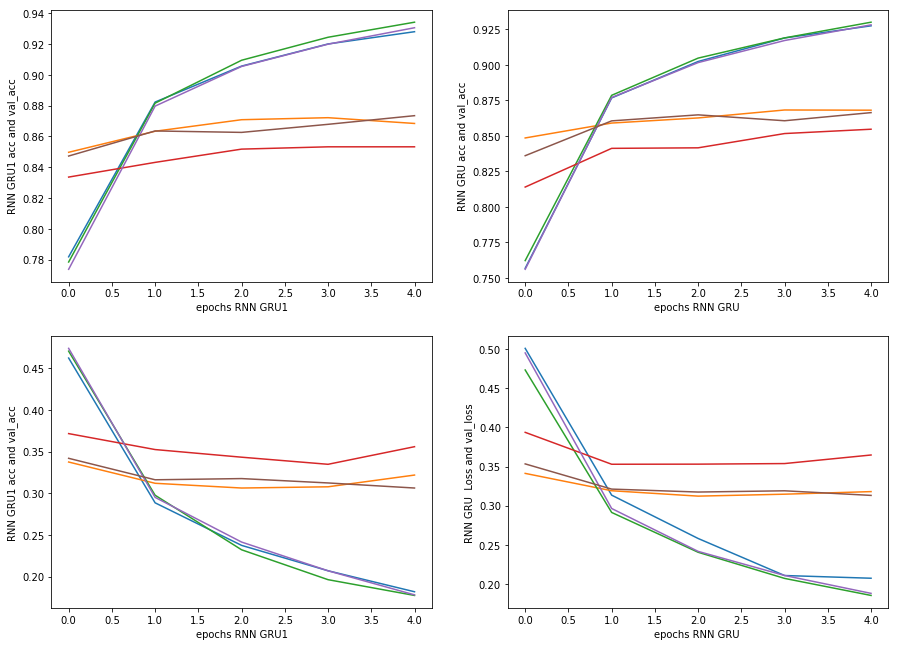

In [813]:
plt.figure(figsize=(15,11))
plt.subplot(2,2,1)
plt.ylabel('RNN GRU1 acc and val_acc')
plt.xlabel('epochs RNN GRU1')
plt.plot(history4[0].history['f1_m'])

plt.plot(history4[0].history['val_f1_m'])
plt.plot(history4[1].history['f1_m'])

plt.plot(history4[1].history['val_f1_m'])
plt.plot(history4[2].history['f1_m'])

plt.plot(history4[2].history['val_f1_m'])
plt.subplot(2,2,3)
plt.ylabel('RNN GRU1 acc and val_acc')
plt.plot(history4[0].history['loss'])
plt.xlabel('epochs RNN GRU1')
plt.plot(history4[0].history['val_loss'])

plt.plot(history4[1].history['loss'])
plt.plot(history4[1].history['val_loss'])
plt.plot(history4[2].history['loss'])
plt.plot(history4[2].history['val_loss']) 
         
plt.subplot(2,2,2)
plt.ylabel('RNN GRU acc and val_acc')
plt.xlabel('epochs RNN GRU ')
plt.plot(history3[0].history['f1_m'])
plt.plot(history3[0].history['val_f1_m'])
plt.plot(history3[1].history['f1_m'])
plt.plot(history3[1].history['val_f1_m'])
plt.plot(history3[2].history['f1_m'])
plt.plot(history3[2].history['val_f1_m'])
plt.subplot(2,2,4)
plt.plot(history2[0].history['loss'])
plt.ylabel('RNN GRU  Loss and val_loss')
plt.plot(history2[0].history['val_loss'])
plt.xlabel('epochs RNN GRU ')
plt.plot(history3[1].history['loss'])
plt.plot(history3[1].history['val_loss'])
plt.plot(history3[2].history['loss'])
plt.plot(history3[2].history['val_loss'])


In [814]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
history5=[]
for train_index, test_index in sss.split(X, y_ohe):
 input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN) # number of words in each sequence
 rnnls2 = Sequential()
 rnnls2.add(input_embed)
 rnnls2.add(GRU(50,return_sequences=True, recurrent_activation='sigmoid',dropout=0.25,recurrent_dropout=0.25))
 rnnls2.add(GRU(10,dropout=0.1,recurrent_dropout=0.1))   
 rnnls2.add(Dense(NUM_CLASSES, activation='sigmoid'))
 rnnls2.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
 print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
 X_train, X_test = X[train_index], X[test_index]
 y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]
 rnnls2.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
 history5.append(rnnls2.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64))
print(rnnls2.summary())


TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 308s 14ms/step - loss: 0.4517 - acc: 0.7800 - f1_m: 0.7713 - val_loss: 0.3531 - val_acc: 0.8461 - val_f1_m: 0.8406
Epoch 2/5
21367/21367 [==============================] - 297s 14ms/step - loss: 0.2933 - acc: 0.8806 - f1_m: 0.8760 - val_loss: 0.3223 - val_acc: 0.8647 - val_f1_m: 0.8589
Epoch 3/5
21367/21367 [==============================] - 340s 16ms/step - loss: 0.2322 - acc: 0.9084 - f1_m: 0.9046 - val_loss: 0.3056 - val_acc: 0.8735 - val_f1_m: 0.8680
Epoch 4/5
21367/21367 [==============================] - 291s 14ms/step - loss: 0.1966 - acc: 0.9238 - f1_m: 0.9215 - val_loss: 0.2992 - val_acc: 0.8753 - val_f1_m: 0.8706
Epoch 5/5
21367/21367 [==============================] - 302s 14ms/step - loss: 0.1697 - acc: 0.9358 - f1_m: 0.9331 - val_loss: 0.3117 - val_acc: 0.8712 - val_f1_m: 0.8693
TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validat

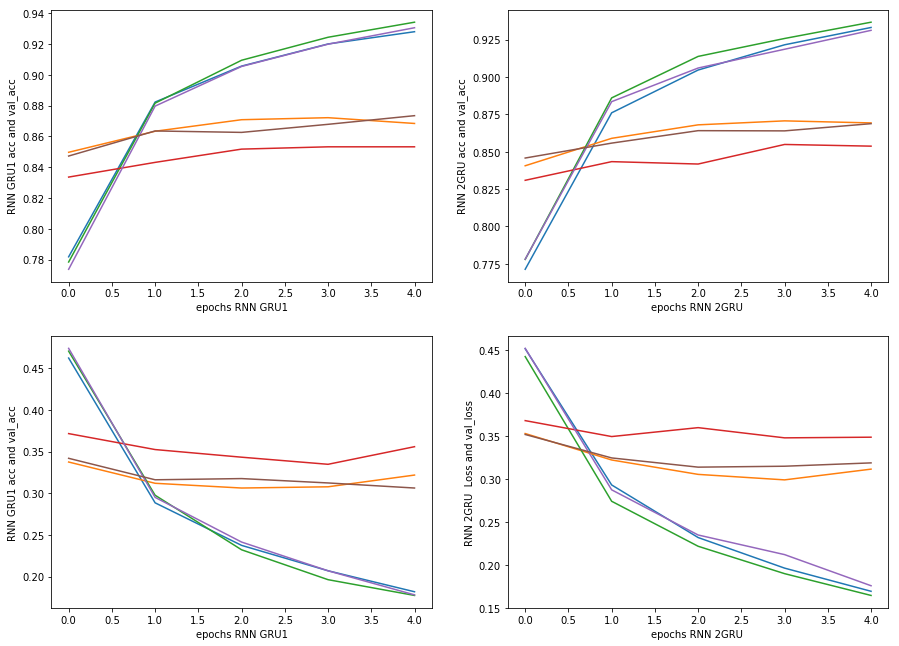

In [815]:
plt.figure(figsize=(15,11))
plt.subplot(2,2,1)
plt.ylabel('RNN GRU1 acc and val_acc')
plt.xlabel('epochs RNN GRU1')
plt.plot(history4[0].history['f1_m'])

plt.plot(history4[0].history['val_f1_m'])
plt.plot(history4[1].history['f1_m'])

plt.plot(history4[1].history['val_f1_m'])
plt.plot(history4[2].history['f1_m'])

plt.plot(history4[2].history['val_f1_m'])
plt.subplot(2,2,3)
plt.ylabel('RNN GRU1 acc and val_acc')
plt.plot(history4[0].history['loss'])
plt.xlabel('epochs RNN GRU1')
plt.plot(history4[0].history['val_loss'])

plt.plot(history4[1].history['loss'])
plt.plot(history4[1].history['val_loss'])
plt.plot(history4[2].history['loss'])
plt.plot(history4[2].history['val_loss']) 
         
plt.subplot(2,2,2)
plt.ylabel('RNN 2GRU acc and val_acc')
plt.xlabel('epochs RNN 2GRU ')
plt.plot(history5[0].history['f1_m'])
plt.plot(history5[0].history['val_f1_m'])
plt.plot(history5[1].history['f1_m'])
plt.plot(history5[1].history['val_f1_m'])
plt.plot(history5[2].history['f1_m'])
plt.plot(history5[2].history['val_f1_m'])
plt.subplot(2,2,4)
plt.plot(history5[0].history['loss'])
plt.ylabel('RNN 2GRU  Loss and val_loss')
plt.plot(history5[0].history['val_loss'])
plt.xlabel('epochs RNN 2GRU ')
plt.plot(history5[1].history['loss'])
plt.plot(history5[1].history['val_loss'])
plt.plot(history5[2].history['loss'])
plt.plot(history5[2].history['val_loss'])


In [816]:
yhat1 = np.argmax(rnnls2.predict(X_test), axis=1)
cm1 = mt.confusion_matrix(y_test_ohe[:,1],yhat)
cm1 = cm1/np.sum(cm1,axis=1)[:,np.newaxis]
print(cm1)


[[0.88121455 0.11878545]
 [0.14797441 0.85202559]]


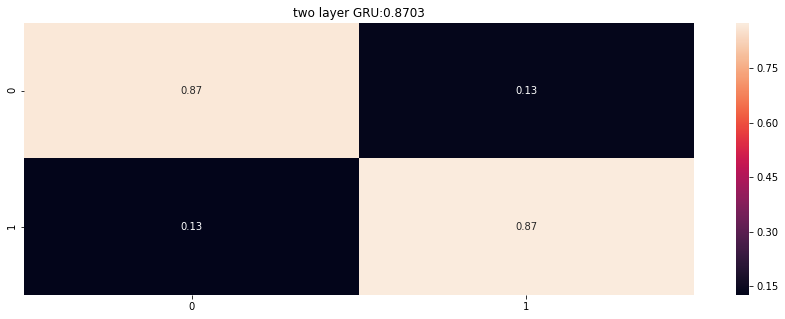

In [824]:
summarize_net(rnnls2, X_test, y_test_ohe[:,1], title_text='two layer GRU:')


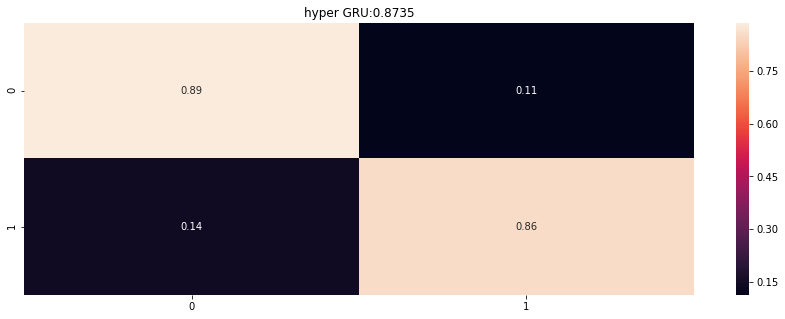

In [825]:
summarize_net(rnnls1, X_test, y_test_ohe[:,1], title_text='hyper GRU:')

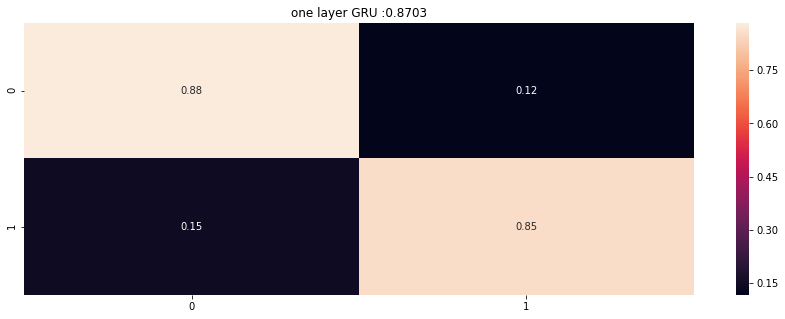

In [826]:
summarize_net(rnngd, X_test, y_test_ohe[:,1], title_text='one layer GRU :')

In [820]:
yhat2 = np.argmax(rnnls1.predict(X_test), axis=1)
cm2 = mt.confusion_matrix(y_test_ohe[:,1],yhat)
cm2 = cm2/np.sum(cm2,axis=1)[:,np.newaxis]
print(cm2)

[[0.88121455 0.11878545]
 [0.14797441 0.85202559]]


In [821]:
yhat3 = np.argmax(rnngd.predict(X_test), axis=1)
cm3 = mt.confusion_matrix(y_test_ohe[:,1],yhat)
cm3 = cm3/np.sum(cm3,axis=1)[:,np.newaxis]
print(cm3)

[[0.88121455 0.11878545]
 [0.14797441 0.85202559]]


In [823]:
# debugging option
#pd.options.display.max_rows = 50

from statsmodels.stats.contingency_tables import mcnemar

# copy ytest for reshape


# build contingency table
contab = pd.DataFrame({'gru_correct':np.equal(y_test_ohe[:,1], yhat3).flatten(),'hyper_gru_correct':np.equal(y_test_ohe[:,1], yhat2).flatten(),'gru2_correct':np.equal(y_test_ohe[:,1], yhat1).flatten()},index=range(0,len(y_test_c)))
xtab = pd.crosstab(contab.gru_correct, contab.hyper_gru_correct)
xtab1 = pd.crosstab(contab.hyper_gru_correct, contab.gru2_correct)
xtab.sort_index(ascending=False, inplace=True)
xtab.sort_index(ascending=False, inplace=True, axis=1)
print('Contingency table for McNemar Test:\n', xtab, '\n')
print('Contingency table for McNemar Test:\n', xtab1, '\n')
# This example taken from https://machinelearningmastery.com/mcnemars-test-for-machine-learning/ and modified for use in this lab
# calculate mcnemar test
result = mcnemar(xtab, exact=False, correction=True)
result1 = mcnemar(xtab1,exact=False, correction=True)
# print findings
print('statistic=%.2f, p-value=%.2f' % (result.statistic, result.pvalue))
print('statistic=%.2f, p-value=%.2f' % (result1.statistic, result1.pvalue))
# compare p-value to alpha
alpha = 0.05
if result.pvalue > alpha:
    print('Same proportions of errors')
else:
    print('Different proportions of errors')

Contingency table for McNemar Test:
 hyper_gru_correct  True   False
gru_correct                    
True                4576     73
False                 90    603 

Contingency table for McNemar Test:
 gru2_correct       False  True 
hyper_gru_correct              
False                584     92
True                 109   4557 

statistic=1.57, p-value=0.21
statistic=1.27, p-value=0.26
Same proportions of errors


mcnemar test was ran on these three classfier :

1- normal GRU

2- optimized GRu

3- two layer GRU 


first on the comparson between normal GRU and optimzed GRU p-value is higher than .05 which means there is a signifcant diffrance between the classfier , and both of the classfier got 4576 correct predection and 603 worng ones on the other hand optimzed GRU was suporior by accuratly predect 90 cases that normal GRU was not able to

then optimized GRU was compared with tow layers GRU , with p-value of .26 we found that optimized GRU is superior to the other classfier which means that adding anther layer worsn that network and overfit it 
